In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from scipy.signal import savgol_filter
import pickle
from struct import *
from binary16 import binary16
from FixedPoint import FXfamily, FXnum
from copy import deepcopy


In [2]:
# Set Flags
DEBUG = False
USE_STORED_DATASET = True

In [3]:
# Utility
def debug_print(*args):
    if DEBUG:
        string = ''
        for arg in args:
            strarg = arg
            if type(arg) != type(''):
                strarg = str(arg)
            string += ' ' + strarg + ' '
        print(string)

# Layers
class Dense:
    def __init__(self, in_size, out_size, act_fwd, act_bwd):
        np.random.seed(seed=2)
        self.W = np.random.rand(out_size, in_size)*1e-1
        self.b = np.random.rand(out_size)*1e-1#np.random.rand(in_size)*0.01
        self.act_fwd = act_fwd
        self.act_bwd = act_bwd
        
    def prop_fwd(self, A):
        self.A = A
        debug_print('A', self.A)
        debug_print('W', self.W)
        self.Z = np.dot(self.W, A)+self.b 
        debug_print('Z', self.Z)
        return self.act_fwd(self.Z)
    
    def prop_bwd(self, dA, Z):
        return self.act_bwd(dA, Z)
        

In [4]:
#Activation, Loss and LR functions
def relu(Z):
    return np.maximum(0,Z)

def relu_grad(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_grad(dA, Z):
    sig = sigmoid(Z)
    return np.convolve(dA, sig * (1 - sig), 'same')#dA * sig * (1 - sig)

def tanh(Z):
    t=(np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    return t

def tanh_grad(dA, Z):
    t=tanh(Z)
    dt=1-t**2
    return dA * dt

def softmax(Z):
    eZ = np.exp(Z - np.max(Z))
    return eZ / eZ.sum(axis=0)

def softmax_grad(dA, Z):
    s = softmax(Z)
    s = Z.reshape(-1,1)
    jacobian = (np.diagflat(s) - np.dot(s, s.T))
    debug_print(dA.shape)
    debug_print(jacobian.shape)
    return np.matmul(dA, jacobian)

def binary_crossentropy_loss(Y_hat, Y): #binary cross entropy
    m = Y_hat.shape[0]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)
    
def binary_crossentropy_loss_grad(Y_hat, Y): #binary cross entropy
    eps = 1e-8
    return -(np.divide(Y, Y_hat+eps) - np.divide(1 - Y, 1 - Y_hat+eps))
    
def multi_cross_entropy(X,y):
    #TODO
    pass

def multi_cross_entropy_grad(X,y):
    #TODO
    pass

def exp_decay(epoch, initiral_lrate, decay):
    #k = 0.1
    lrate = initiral_lrate * np.exp(-decay*epoch)
    return lrate

In [5]:
#Simple verbose debugging example
d1 = Dense(8,4,tanh, tanh_grad)
d2 = Dense(4,2,softmax, softmax_grad)
y = np.array([1.0, 0.0])
DEBUG=True
#d1.W *= 1e1
#d2.W *= 1e-1
for i in range(7):
    debug_print('------FWD------')
    y_hat = 1-d2.prop_fwd(d1.prop_fwd(np.ones(8)))
    debug_print('Y_hat', y_hat)
    alpha = 1.0e-7
    
    debug_print('\n------BWD------')
    debug_print('D2')
    dA = binary_crossentropy_loss_grad(y_hat, y)
    debug_print('dA', dA)
    dZ = d2.prop_bwd(dA, d2.Z)
    debug_print('dZ', dZ)
    dW = np.array([np.array([np.sum(d2.A)*z]) for z in dZ])/d2.A.shape[0]
    debug_print('dW', dW)
    db = np.sum(dZ, axis=0, keepdims=True)/d2.A.shape[0]
    dA = np.dot(d2.W.T, dZ)
    debug_print('PRE', d2.W)
    d2.W -= dW#*alpha
    debug_print('POST', d2.W)
    d2.b -= db#*alpha
    
    debug_print('D1')
    debug_print('dA', dA)
    dZ = d1.prop_bwd(dA, d1.Z)
    #print(dZ.shape)
    debug_print('dZ', dZ)
    dW = np.array([np.array([np.sum(d1.A)*z]) for z in dZ])/d1.A.shape[0]
    debug_print('dW', dW)
    db = np.sum(dZ, axis=0, keepdims=True)/d1.A.shape[0]
    dA = np.dot(d1.W.T, dZ)
    debug_print('PRE', d1.W)
    d1.W -= dW*alpha
    debug_print('POST', d1.W)
    d1.b -= db*alpha
DEBUG=False

 ------FWD------ 
 A  [1. 1. 1. 1. 1. 1. 1. 1.] 
 W  [[0.04359949 0.00259262 0.05496625 0.04353224 0.04203678 0.03303348
  0.02046486 0.0619271 ]
 [0.02996547 0.02668273 0.06211338 0.05291421 0.01345799 0.05135781
  0.01844399 0.07853351]
 [0.08539753 0.04942368 0.08465615 0.00796455 0.05052461 0.00652865
  0.04281223 0.00965309]
 [0.012716   0.05967453 0.0226012  0.01069457 0.02203062 0.03498263
  0.04677875 0.02017432]] 
 Z  [0.3661935  0.38177608 0.38748417 0.26834188] 
 A  [0.35065773 0.3642489  0.36918932 0.26208128] 
 W  [[0.04359949 0.00259262 0.05496625 0.04353224]
 [0.04203678 0.03303348 0.02046486 0.0619271 ]] 
 Z  [0.07790026 0.077241  ] 
 Y_hat  [0.49983518 0.50016482] 
 
------BWD------ 
 D2 
 dA  [-2.00065944  2.00065944] 
 (2,) 
 (2, 2) 
 dZ  [-0.15574915  0.15463481] 
 dW  [[-0.05241649]
 [ 0.05204147]] 
 PRE  [[0.04359949 0.00259262 0.05496625 0.04353224]
 [0.04203678 0.03303348 0.02046486 0.0619271 ]] 
 POST  [[ 0.09601598  0.05500911  0.10738274  0.09594873]
 [-0.010

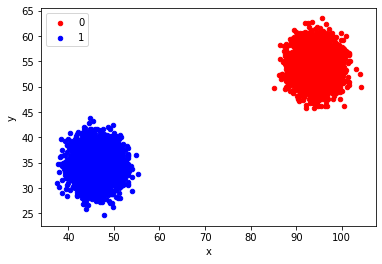

In [6]:
# Generate Dataset
# You might have to do this several times, not all datasets seem
# to have a distribution that can be handled by this simple NN.
# I recommend storing exampls of particular intrest on disk for later usage.


num_classes = 2
num_features = 8
USE_STORED_DATASET = True
if not USE_STORED_DATASET:
    X, y = make_blobs(n_samples=10000, centers=num_classes, n_features=num_features, cluster_std=0.25, shuffle=True)
        
    with open( "X.p", "wb" ) as ofile:
        pickle.dump(X, ofile)

    with open( "y.p", "wb" ) as ofile:
        pickle.dump(y, ofile)

elif USE_STORED_DATASET:
    with open( "X.p", "rb" ) as ofile:
        X = pickle.load(ofile)

    with open( "y.p", "rb" ) as ofile:
        y = pickle.load(ofile)

X*=10
Y = np.zeros(shape = (len(y), num_classes))
for ind, label in enumerate(y):
    Y[ind][label] = 1.0
    
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


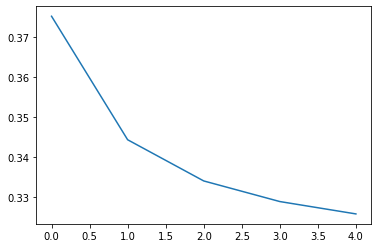

mean top layer gradient: 4.12040059949056e-05


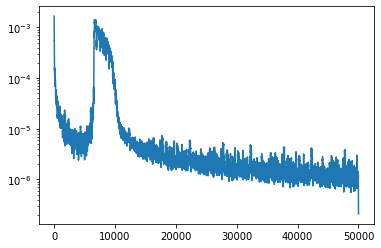

train accuracy 1.0


In [7]:
# Gradient Descent
# with gradient amplification [1], normalization [2]
# and architecture-dependent initial weights amplification
# to counter vanishing gradients problem.
# [1] https://arxiv.org/pdf/2006.10560.pdf
# [2] https://arxiv.org/pdf/2006.12169.pdf
layers = [
    Dense(num_features, 4, tanh, tanh_grad),
    Dense(4,2, tanh, tanh_grad),
    Dense(2, num_classes, softmax, softmax_grad)]

# Architecture-dependent initial weights amplification
# This trick is based on the asumption that at least partially,
# the vanishing gradient problem can be reduced by choosing the initial
# weights distribution s.t. weights gradients in the upper layers
# are large for the first couple of iterations. This is the case
# if the weights get larger towards tthe bottom layer because the larger
# the weights in the bottom layer are, the more adjustment they will receive
# in the beginning of training. Likewise, we choose bias in an inverted strategy,
# ensuring that training impacts on bias are low for the bottom layer at the beginning,
# becoming larger as training progresses. 
# Update: Actually someone had a similar idea already:
# http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

# TODO: 
# Add the difference between adjunct layer weight matrices and their distributions somehow. 
# Current calculation based only on the current layers weight matrix shape and changing exponents.

MOD_WEIGHTS = False
max_power = 10
if MOD_WEIGHTS == True:
    k = len(layers)
    for i in range(0, k-1, 1):
        fact = 1.0 + ((layers[i].W.shape[0]*layers[i].W.shape[1])/
        (layers[i+1].W.shape[0]*layers[i+1].W.shape[1]))
        layers[k-1-i].W*=fact
        print(fact)

epochs = 5
alpha = 1.0e-3 # initial learning rate
beta = 1e-3 # decay rate
iteration_loss = []
epoch_loss = []
mean_grads_top_layer = []
DEBUG=False
for i  in range(epochs):
    for j, sample in enumerate(X):
        intermediate = sample
        for layer in layers:
            intermediate = layer.prop_fwd(intermediate)
        Y_hat = intermediate
        iteration_loss.append(binary_crossentropy_loss(Y_hat, Y[j]))
        
        dA = binary_crossentropy_loss_grad(Y_hat, Y[j])
        layers.reverse()
        updW = []
        updB = []
        for k, layer in enumerate(layers):
            dZ = layer.prop_bwd(dA, layer.Z)
            dW = np.array([np.array([np.sum(layer.A)*z]) for z in dZ])/layer.A.shape[0]
            db = np.sum(dZ, axis=0, keepdims=True)/layer.A.shape[0]
            dA = np.dot(layer.W.T, dZ)
            gradient_normalizer = np.abs(1.0/dA) # Gradient normalization and amplification
            gradient_amplifier = max(dA.shape[0], layer.W.shape[0])/min(dA.shape[0], layer.W.shape[0])
            dA*=gradient_normalizer*gradient_amplifier
            updW.append(dW*exp_decay(i, alpha, beta))
            updB.append(db*exp_decay(i, alpha, beta))
        
        for k, W in enumerate(updW):
            if k == len(updW)-1: mean_grads_top_layer.append(np.abs(W.mean()))
            layers[k].W -= W
            layers[k].b -= updB[k]
        layers.reverse()
        
    epoch_loss.append(np.array(iteration_loss).mean())
        
        
correct = 0
pyplot.yscale('linear')
pyplot.plot(epoch_loss) 
pyplot.show()

#mean_grads_top_layer.reverse()
pyplot.yscale('log')
pyplot.plot(savgol_filter(mean_grads_top_layer, 51, 1))
print('mean top layer gradient:',  np.array(mean_grads_top_layer).mean())
pyplot.show()

for j, x in enumerate(X):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1
print('train accuracy', correct/len(Y))

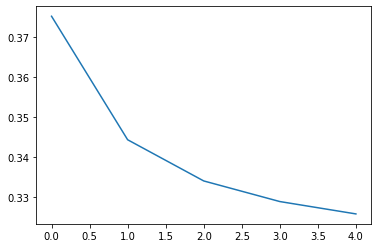

mean top layer gradient: 4.12040059949056e-05


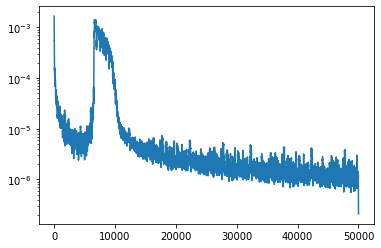

In [8]:
#Plots without archticteure-aware weights initialization 
pyplot.yscale('linear')
pyplot.plot(epoch_loss) 
pyplot.show()

pyplot.yscale('log')
pyplot.plot(savgol_filter(mean_grads_top_layer, 51, 1)) 
print('mean top layer gradient:', np.array(mean_grads_top_layer).mean())
pyplot.show()

In [9]:
for j, x in enumerate(X):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
        #print(Y_hat)
    
    DEBUG=False
    debug_print('NN:', np.around(Y_hat, decimals=5), 'LABEL:',Y[j])
    DEBUG=False
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1

In [10]:
layers = [
    Dense(num_features, 4,tanh, tanh_grad),
    Dense(4,2, tanh, tanh_grad),
    Dense(2, num_classes, softmax, softmax_grad)]

k = len(layers)
stepsize = int(max_power/k)

#print(num_features)
#print((layers[0].W.shape[0]*layers[0].W.shape[1]), '\n')

for i in range(0, k-1, 1):
    #ratio = (min(layers[i].W.shape[0], layers[i].W.shape[1])/
    #         max(layers[i].W.shape[0], layers[i].W.shape[1]))
    #power = 1.0/np.power(10, stepsize*i)
    #print(layers[i].W.shape[0]*layers[i].W.shape[1])
    #print(layers[i-1].W.shape[0]*layers[i-1].W.shape[1])
    
    #print((layers[i].W.shape[0]*layers[i].W.shape[1]))
    #print((layers[i+1].W.shape[0]*layers[i+1].W.shape[1]))
    print(i,'to',i+1)
    fact = 1.0 + (layers[i].W.shape[0]*layers[i].W.shape[1])/(layers[i+1].W.shape[0]*layers[i+1].W.shape[1])
    print('fact', fact)
    
    print((layers[i].W.shape[0]*layers[i].W.shape[1])/(layers[i+1].W.shape[0]*layers[i+1].W.shape[1]))
    #print('i', i)
    #print('power', power)
    #print('ratio', ratio)
    #layers[k-1-i].W *= power * ratio
    #layers[i].b *= power * ratio
    #print('W', layers[i].W,'\n')

layers[0].W*=0.5
layers[1].W*=1.5
layers[2].W*=2.5


0 to 1
fact 5.0
4.0
1 to 2
fact 3.0
2.0


0.0005156837967240497
0.0003155022767954518
0.0003975347571317353
0.03756984463285778
0.03776910284933438
0.03617265011167203
5.0
3.0
0.0005156837967240497
0.0028395204911590664
0.00993836892829338
0.03756984463285778
0.11330730854800315
0.18086325055836014


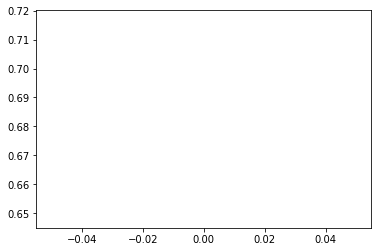

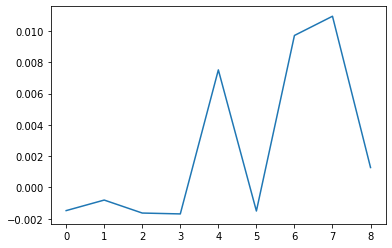

train accuracy 0.8172


In [25]:
# Mini Batch Gradient Descent
# with gradient amplification [1], normalization [2]
# and architecture-dependen initial weights amplification
# to counter vanishing gradients problem.
# [1] https://arxiv.org/pdf/2006.10560.pdf
# [2] https://arxiv.org/pdf/2006.12169.pdf
#X=10
layers = [
    Dense(num_features, 4,relu, relu_grad),
    Dense(4,2, relu, relu_grad),
    Dense(2, num_classes, softmax, softmax_grad)]

# Architecture-dependent initial weights amplification
# This trick is based on the asumption that at least partially,
# the vanishing gradient problem can be reduced by choosing the initial
# weights distribution s.t. weights gradients in the upper layers
# are large for the first couple of iterations. This is the case
# if the weights get larger towards tthe bottom layer because the larger
# the weights in the bottom layer are, the more adjustment they will receive
# in the beginning of training. Likewise, we choose bias in an inverted strategy,
# ensuring that training impacts on bias are low for the bottom layer at the beginning,
# becoming larger as training progresses.
# Update: Actually someone had a similar idea already:
# http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

# TODO: 
# Add the difference between adjunct layer weight matrices and their distributions somehow. 
# Current calculation based only on the current layers weight matrix shape and changing exponents.
MOD_WEIGHTS = True
max_power = 2

print(layers[0].W.var())
print(layers[1].W.var())
print(layers[2].W.var())
print(layers[0].W.mean())
print(layers[1].W.mean())
print(layers[2].W.mean())

if MOD_WEIGHTS == True:
    k = len(layers)
    for i in range(0, k-1, 1):
        fact = 1.0 + ((layers[i].W.shape[0]*layers[i].W.shape[1])/
        (layers[i+1].W.shape[0]*layers[i+1].W.shape[1]))
        layers[k-1-i].W*=fact
        print(fact)

print(layers[0].W.var())
print(layers[1].W.var())
print(layers[2].W.var())
print(layers[0].W.mean())
print(layers[1].W.mean())
print(layers[2].W.mean())

#layers[0].W*=1.0
#layers[1].W*=3.0
#layers[2].W*=5.0

batch_size = 1000
epochs = 1
alpha = 9.0e-1
beta = 1e-3
iteration_loss = []
epoch_loss = []
DEBUG=False
batch_no = 0
mean_grads_top_layer = []
for i  in range(epochs):
    while (batch_no+1)*batch_size < len(X):
        dA = 0.0
        for j, sample in enumerate(X[batch_no*batch_size:(batch_no+1)*batch_size]):
            intermediate = sample
            for layer in layers:
                intermediate = layer.prop_fwd(intermediate)
            Y_hat = intermediate
            iteration_loss.append(binary_crossentropy_loss(Y_hat, Y[batch_no*batch_size+j]))
            dA += binary_crossentropy_loss_grad(Y_hat, Y[batch_no*batch_size+j])

        layers.reverse()
        updW = []
        updB = []
        for k, layer in enumerate(layers):
            dZ = layer.prop_bwd(dA/batch_size, layer.Z)
            dW = np.array([np.array([np.sum(layer.A)*z]) for z in dZ])/layer.A.shape[0] # This should
            db = np.sum(dZ, axis=0, keepdims=True)/layer.A.shape[0]
            dA = np.dot(layer.W.T, dZ) 
            gradient_normalizer = np.abs(1.0/dA)  # Gradient normalization and amplification
            gradient_amplifier = max(dA.shape[0], layer.W.shape[0])/min(dA.shape[0], layer.W.shape[0])
            dA*=gradient_normalizer*gradient_amplifier
            updW.append(dW*exp_decay(batch_no*i, alpha, beta))
            updB.append(db*exp_decay(batch_no*i, alpha, beta))

        for k, W in enumerate(updW):
            if k == len(updW)-1: mean_grads_top_layer.append(W.mean())
            layers[k].W -= W
            layers[k].b -= updB[k]
        layers.reverse()
        batch_no+=1

    epoch_loss.append(np.array(iteration_loss).mean())
        
        
correct = 0
pyplot.plot(epoch_loss) 
pyplot.show()
pyplot.plot(mean_grads_top_layer) 
pyplot.show()
Y_target = deepcopy(Y) #Required by BFA
for j, x in enumerate(X):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1
    Y_target[j] = Y_hat
print('train accuracy', correct/len(Y))

In [32]:
# Bitlfip attack
# https://arxiv.org/abs/1903.12269
# https://stackoverflow.com/questions/34615590/python-flip-a-bit-in-a-float


def bitflip_single(x,pos):
    fs = pack('f',x)
    bval = list(unpack('BBBB',fs))
    [q,r] = divmod(pos,8)
    bval[q] ^= 1 << r
    fs = pack('BBBB', *bval)
    fnew=unpack('f',fs)
    return fnew[0]

def bitflip_double(x,pos):
    fs = pack('d',x)
    bval = list(unpack('BBBBBBBB',fs))
    [q,r] = divmod(pos,8)
    bval[q] ^= 1 << r
    fs = pack('BBBBBBBB', *bval)
    fnew=unpack('d',fs)
    return fnew[0]

def bindigits(n, bits):
    s = bin(n & int("1"*bits, 2))[2:]
    return ("{0:0>%s}" % (bits)).format(s)

def twosComplement (value, bitLength) :
    return bin(value & (2**bitLength - 1))

def bitflip_int(x,pos):
    fs = pack('i',x)
    bval = list(unpack("BBBB",fs))
    [q,r] = divmod(pos,8)
    bval[q] ^= 1 << r
    fs = pack('BBBB', *bval)
    fnew=unpack('i',fs)
    return fnew[0]

def FP2int(x : FXnum, prec : int, base : int = 10) -> int:
    x = x*base**prec
    return int(x)

def int2FP(x : int, prec : int, base : int = 10) -> FXnum :
    return FXfamily(prec)(x)/base**prec

def flip_FP(x, pos, prec):
    return np.float64(
        int2FP(
            bitflip_int(
                FP2int(
                    FXfamily(prec)(x), prec
                ), pos
            ), prec
        )
    )

def fwd(layers, x):
    Y_hat = x
    for layer in layers:
        Y_hat = layer.prop_fwd(Y_hat)
    return Y_hat

def bwd(layers, Y, Y_hat, layer_idx):
    dA = binary_crossentropy_loss_grad(Y_hat, Y[j])
    layers.reverse()
    gradients = []
    for k, layer in enumerate(layers):
        dZ = layer.prop_bwd(dA/batch_size, layer.Z)
        dW = np.array([np.array([np.sum(layer.A)*z]) for z in dZ])/layer.A.shape[0] # This should
        db = np.sum(dZ, axis=0, keepdims=True)/layer.A.shape[0]
        dA = np.dot(layer.W.T, dZ) 
        gradients.append(dW)
    layers.reverse()
    return gradients[layer_idx]
    
def BFA(layers, msb, prec, n, Y, X):
    # https://arxiv.org/pdf/1903.12269.pdf
    #In Layer Search:
    x = [0]
    class GradPos:
        def __init__(self, grad, layer_idx, w_row_idx, w_col_idx, bit):
            self.grad = grad
            self.layer_idx = layer_idx
            self.w_row_idx = w_row_idx
            self.w_col_idx = w_col_idx
            self.bit = bit
            
    class GradPosContainer:
        def __init__(self, n):
            self.n = n
            self.grads_pos_container = []
            
        def min_grad_pos(self, layer_idx):
            min_grad = None
            min_pos = 0
            for pos, grad_pos in enumerate(self.grads_pos_container):
                if min_grad is None:
                    if layer_idx == grad_pos.layer_idx:
                        min_grad = grad_pos.grad
                        min_pos = pos
                if layer_idx == grad_pos.layer_idx:
                    if (np.greater(np.abs(np.array(grad_pos.grad)), np.abs(np.array(min_grad))).all()):
                        min_pos = pos
            return min_pos
        
        def store(self, grad_pos):
            if len(self.grads_pos_container) < self.n:
                self.grads_pos_container.append(grad_pos)
            else:
                exchange_pos = self.min_grad_pos(grad_pos.layer_idx)
                self.grads_pos_container[exchange_pos] = grad_pos
                
        def quantize(self, layers, msb, prec):
            #N-bits uniform quantizer
            for i,_ in enumerate(layers):
                dw = layers[i].W.max()/(2**(prec-1)-1)
                layers[i].W = np.round(layers[i].W/dw)*dw
                print(layers[i].W)
            return layers
        
        def search_in_layer(self, layer, X, Y, i):
            for j,_ in enumerate(layer.W):
                for k,_ in enumerate(layer.W[j]):
                    for l in range(prec):
                        w_old = deepcopy(layer.W[j][k])
                        # b.c. b_i in the binary weight representation can only 0 or 1,
                        # this should get us the correct gradient, i.e. dL/db_i
                        layer.W[j][k] = flip_FP(layer.W[j][k], l, prec)
                        Y_hat = fwd(layers, X[0])
                        grad = bwd(layers, Y, Y_hat, i)
                        layer.W[j][k] =  deepcopy(w_old)
                        self.store(GradPos(grad, i,j,k,l))
                            
        def search_cross_layer(self, layers, X, Y):
            for i, layer in enumerate(layers):
                self.search_in_layer(layer, X, Y, i)
            
    grads_pos_container = GradPosContainer(n)
    layers = grads_pos_container.quantize(layers, msb, prec)
    grads_pos_container.search_cross_layer(layers, X, Y)

    # Apply attack
    x = 0
    for grad_pos in grads_pos_container.grads_pos_container:
        x += 1
        print(x)
        #TODO masking approach, still naive approach
        weight = layers[grad_pos.layer_idx].W[grad_pos.w_row_idx][grad_pos.w_col_idx]
        weight = flip_FP(weight, grad_pos.bit, prec)
        layers[grad_pos.layer_idx].W[grad_pos.w_row_idx][grad_pos.w_col_idx] = weight
    
    return layers

layers_old = deepcopy(layers)
layers_new = BFA(layers = layers, msb = 31, prec = 8, n = 2, Y=Y_target, X=X)
layers = deepcopy(layers_old)

[[ 0.0287918  -0.01212286  0.04015698  0.0287918   0.02727644  0.01818429
   0.00530375  0.04697609]
 [-0.01288054 -0.01591126  0.01969965  0.0106075  -0.0287918   0.00909215
  -0.02424572  0.03561091]
 [ 0.09622521  0.06061431  0.09546753  0.01894197  0.06137199  0.01742661
   0.0537952   0.02045733]
 [-0.02954947  0.01742661 -0.01969965 -0.03182251 -0.02045733 -0.00757679
   0.00454607 -0.02273037]]
[[ 0.12205199 -0.          0.15651373  0.12205199]
 [ 0.12205199  0.09620568  0.05743623  0.18236003]]
[[0.26329341 0.05804894]
 [0.22597623 0.17000047]]
1
2


In [33]:
correct = 0
for j, x in enumerate(X):
    Y_hat = x
    for layer in layers_new:
        Y_hat = layer.prop_fwd(Y_hat)
    if (np.around(Y_hat, decimals=0) == Y[j]).all():
        correct+=1
        
    if j < 10:
        DEBUG=True
        debug_print('NN:', np.around(Y_hat, decimals=5), 'LABEL:',Y[j])
        DEBUG=False
print('train accuracy', correct/len(Y))

 NN:  [0.50126 0.49874]  LABEL:  [1. 0.] 
 NN:  [0.49973 0.50027]  LABEL:  [0. 1.] 
 NN:  [0.50039 0.49961]  LABEL:  [0. 1.] 
 NN:  [0.50126 0.49874]  LABEL:  [1. 0.] 
 NN:  [0.49995 0.50005]  LABEL:  [0. 1.] 
 NN:  [0.50001 0.49999]  LABEL:  [0. 1.] 
 NN:  [0.50076 0.49924]  LABEL:  [0. 1.] 
 NN:  [0.50125 0.49875]  LABEL:  [1. 0.] 
 NN:  [0.50127 0.49873]  LABEL:  [1. 0.] 
 NN:  [0.50045 0.49955]  LABEL:  [0. 1.] 
train accuracy 0.7017


In [14]:
print(layers_new[0].W, '\n')
print(layers_new[1].W, '\n')
print(layers_new[2].W, '\n')

[[0.03125    0.         0.05513856 0.0437074  0.04236255 0.03294865
  0.02017264 0.06186278]
 [0.03025897 0.02689686 0.06186278 0.0531213  0.01344843 0.05110403
  0.01815538 0.07867331]
 [0.08539753 0.04975919 0.08472511 0.00806906 0.05043161 0.00672421
  0.04303498 0.0094139 ]
 [0.01277601 0.05984551 0.02286233 0.01075874 0.02218991 0.03496592
  0.0390625  0.01953125]] 

[[0.13019319 0.00731422 0.16530146 0.13019319]
 [0.12580465 0.09947345 0.06143948 0.18578129]] 

[[0.21856658 0.01298415]
 [0.27483124 0.21484375]] 



In [15]:
print(layers[0].W, '\n')
print(layers[1].W, '\n')
print(layers[2].W, '\n')

[[0.04359949 0.00259262 0.05496625 0.04353224 0.04203678 0.03303348
  0.02046486 0.0619271 ]
 [0.02996547 0.02668273 0.06211338 0.05291421 0.01345799 0.05135781
  0.01844399 0.07853351]
 [0.08539753 0.04942368 0.08465615 0.00796455 0.05052461 0.00652865
  0.04281223 0.00965309]
 [0.012716   0.05967453 0.0226012  0.01069457 0.02203062 0.03498263
  0.04677875 0.02017432]] 

[[0.13079847 0.00777787 0.16489874 0.13059672]
 [0.12611034 0.09910045 0.06139459 0.18578129]] 

[[0.21799745 0.01296312]
 [0.27483124 0.2176612 ]] 

